In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import sys
from os import listdir
from os.path import isfile, join, exists
from scipy.spatial.distance import pdist, squareform
import scipy.io as sio
import scipy.stats as stats
from tqdm import tqdm
import time
import pymatreader
from IPython.core.debugger import set_trace
import copy
import h5py

import matplotlib.pyplot as plt

In [2]:
def make_img_stack(vol):
    assert(np.ndim(vol)==3)
    n = vol.shape[2]
    s = int(np.ceil(np.sqrt(n)))
    
    X = []
    c = 0
    for i in range(s):
        X_ = []
        for j in range(s):
            try:
                X_.append(np.squeeze(vol[:,:,c]))
            except:
                X_.append(np.zeros((vol.shape[0],vol.shape[1])))
            c+=1
        X_ = np.hstack(X_)
        X.append(X_)
    X = np.vstack(X)
    return X
    

/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in greater
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice


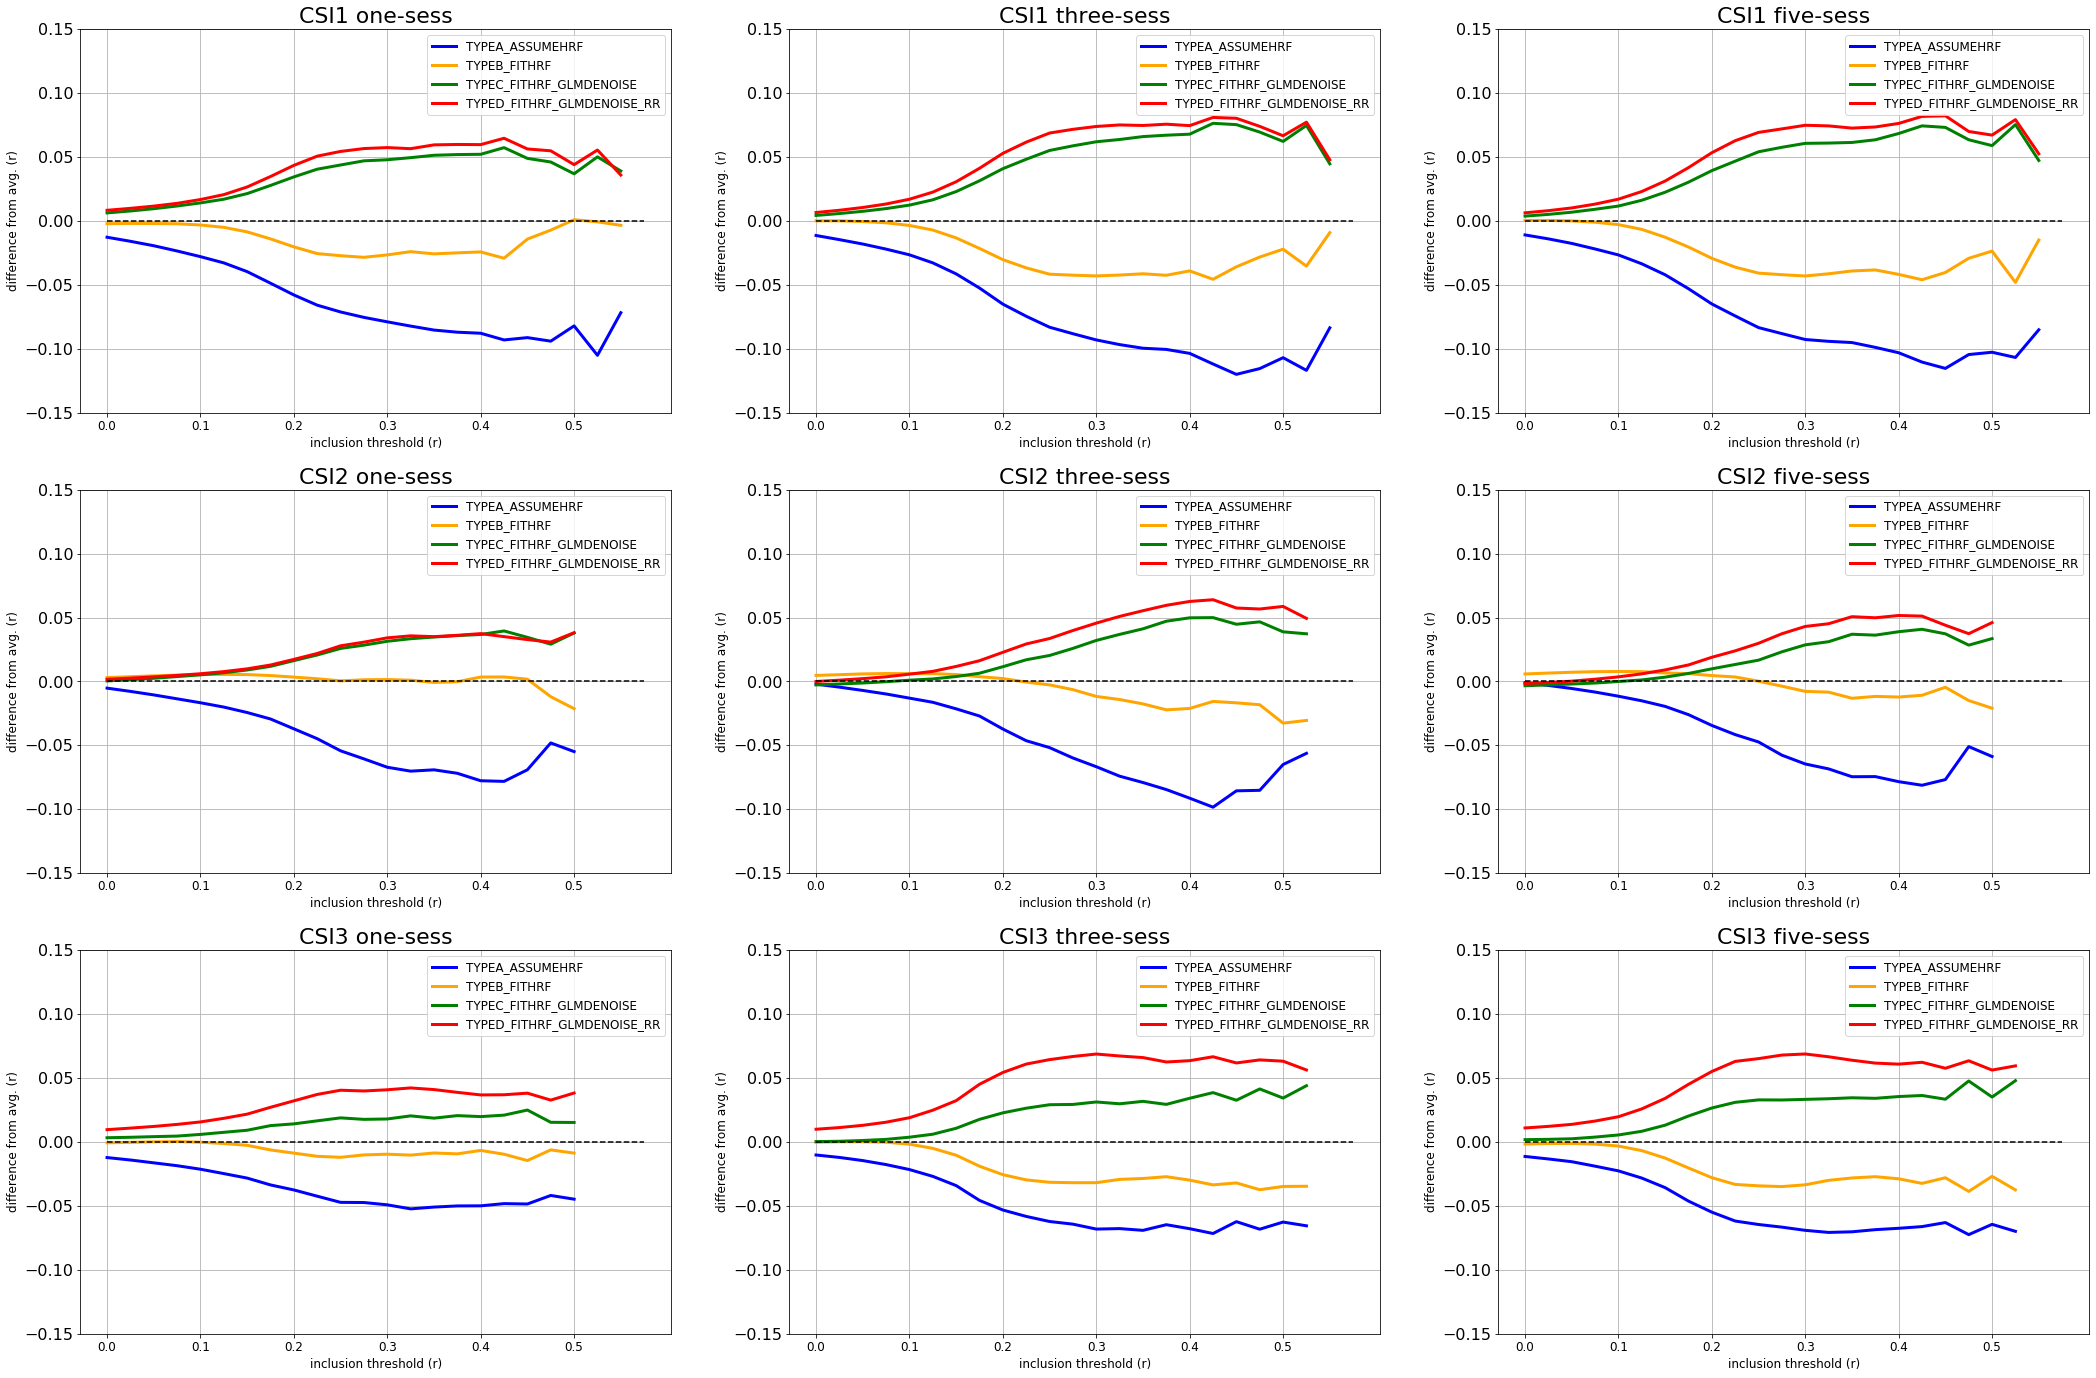

In [3]:
metric = 'reliability' #,'ncsnr','reliability']
if 'v' in metric:
    clims = (0.80,1.04)
    vals = np.round(np.arange(0.6,1.5,0.01),2)
elif 'snr' in metric:
    clims = (0, 70)
    vals = np.round(np.arange(0,70,1),2)
elif 'rel' in metric:
    clims = (-0.2,0.2)
    vals = np.round(np.arange(0,0.6,0.025),3)

dates = ['08_24_20']#,'08_14_20']
subjs = ['CSI1','CSI2','CSI3']
groupings = ['one-sess','three-sess','five-sess']
versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPEC_FITHRF_GLMDENOISE', 'TYPED_FITHRF_GLMDENOISE_RR']
ft = 16
colors = ['blue','orange','green','red']

s = 1
plt.figure(figsize=(36,24))

for subj in subjs:

    for grouping in groupings:

        for date in dates:
            
            if '24' in date:
                linealpha = 1
            else:
                linealpha = 0.5
                
            metricdir = f'/home/jacobpri/git/BOLD5000-GLMs/betas/{date}_{grouping}/metrics'
            assert(exists(metricdir))

            files = os.listdir(metricdir)
            subj_files = [file for file in files if subj in file and metric in file]

            all_metrics = []

            for version in versions:
                fn = join(metricdir, f'{subj}_{version}_{metric}')
                all_metrics.append(sio.loadmat(fn)[metric])

            subj_mean_metric = np.nanmean(np.stack(all_metrics,axis=3),axis=3)

            plt.subplot(3,3,s)
            c = 0
            for version in versions:
                results = []
                for val in vals:
                    if 'v' in metric:
                        mask = subj_mean_metric < val
                    else:
                        mask = subj_mean_metric > val

                    X_this_version = all_metrics[c][mask]    # get voxel metric values from this beta version 
                    X_mean_version = subj_mean_metric[mask]  # get voxel metric values from the version-averaged data
                    X_diff = X_this_version - X_mean_version # voxel-wise subtraction
                    results.append(np.nanmean(X_diff)) # take the mean of the difference
                    
                    
                    #proportions.append(100*(np.nanmean(X_this_version)/np.nanmean(X_mean_version)-1))
                    #proportions.append(np.nanmedian(X_this_version))
                plt.plot(results,linewidth=3,color = colors[c],alpha=linealpha)
                c+=1

        plt.plot(np.zeros((len(vals),)),'k--')
        plt.xticks(np.arange(len(vals))[::4],np.array(vals[::4]),fontsize=ft-4);
        plt.legend(versions,fontsize=ft-4)
        plt.ylim([-0.15,0.15])
        plt.yticks(fontsize=ft)
        plt.grid('on')
        plt.title(f'{subj} {grouping}',fontsize=ft+6)
        plt.xlabel('inclusion threshold (r)',fontsize=ft-4)
        plt.ylabel('difference from avg. (r)',fontsize=ft-4)
        s+=1

/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less_equal


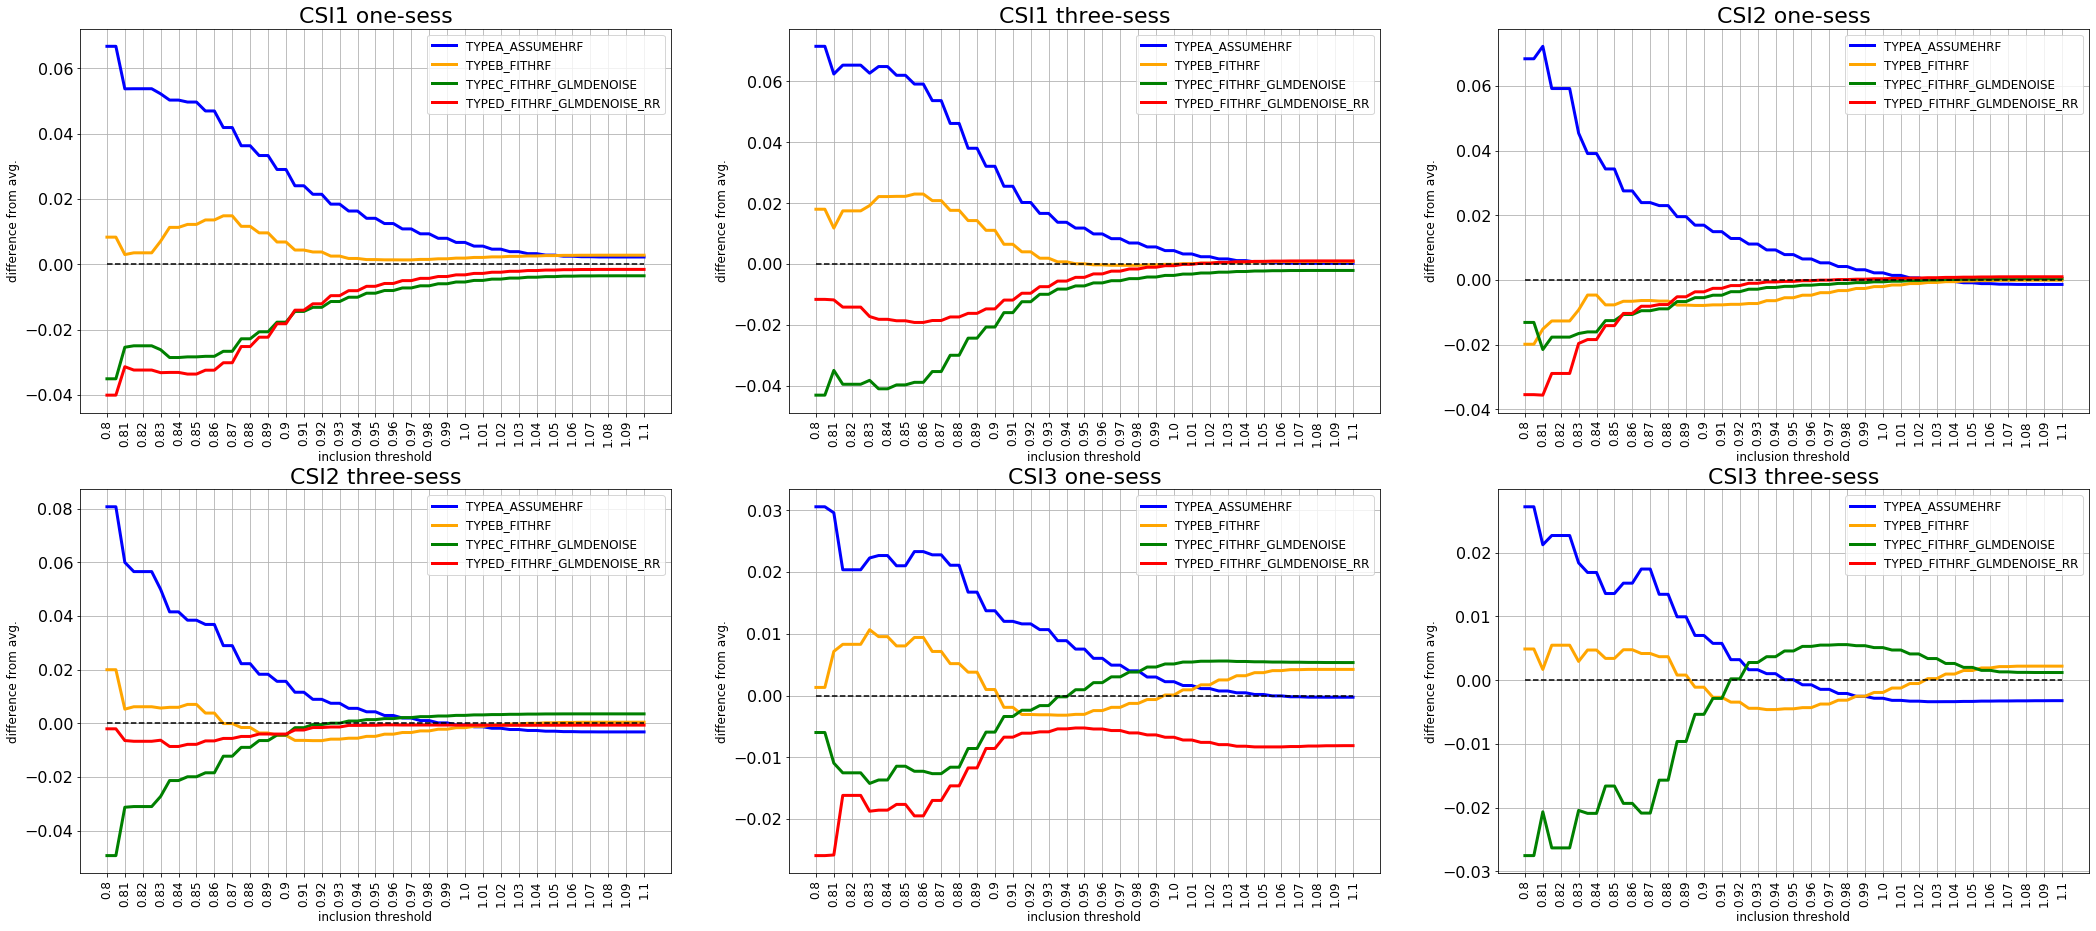

In [43]:
metric_sort = 'vmetric' #,'ncsnr','reliability']
metric = 'vmetric'
if 'v' in metric_sort:
    clims = (0.80,1.04)
    vals = np.round(np.arange(0.8,1.1,0.005),2)
elif 'snr' in metric_sort:
    clims = (0, 70)
    vals = np.round(np.arange(0,70,1),2)
elif 'rel' in metric_sort:
    clims = (-0.2,0.2)
    vals = np.round(np.arange(-0.1,0.6,0.025),3)

dates = ['08_24_20']#,'08_14_20']
subjs = ['CSI1','CSI2','CSI3']
groupings = ['one-sess','three-sess']#,'five-sess']
versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPEC_FITHRF_GLMDENOISE', 'TYPED_FITHRF_GLMDENOISE_RR']
ft = 16
colors = ['blue','orange','green','red']

s = 1
plt.figure(figsize=(36,24))

for subj in subjs:

    for grouping in groupings:

        for date in dates:
            
            if '24' in date:
                linealpha = 1
            else:
                linealpha = 0.5
                
            metricdir = f'/home/jacobpri/git/BOLD5000-GLMs/betas/{date}_{grouping}/metrics_v2'
            assert(exists(metricdir))

            files = os.listdir(metricdir)
            #subj_files = [file for file in files if subj in file and metric in file]

            all_metrics = []
            all_metrics_sort = []

            for version in versions:
                fn = join(metricdir, f'{subj}_{version}_{metric}')
                fn_sort = join(metricdir, f'{subj}_{version}_{metric_sort}')
                try:
                    metricA = sio.loadmat(fn)[metric]
                except:
                    continue
                if 'v' in metric:
                    #metricA[metricA < 0.9] = np.nan
                    metricA[metricA > 1.1] = np.nan
                all_metrics.append(metricA)
                metricB = sio.loadmat(fn_sort)[metric_sort]
                if 'v' in metric_sort:
                    #metricB[metricB < 0.9] = np.nan
                    metricB[metricB > 1.1] = np.nan
                all_metrics_sort.append(metricB)

            subj_mean_metric = np.nanmean(np.stack(all_metrics,axis=3),axis=3)
            subj_mean_metric_sort = np.nanmean(np.stack(all_metrics_sort,axis=3),axis=3)

            plt.subplot(3,3,s)
            c = 0
            for version in versions:
                results = []
                counts = []
                for val in vals:
                    if 'v' in metric_sort:
                        mask = subj_mean_metric_sort <= val
                    else:
                        mask = subj_mean_metric_sort >= val

                    #print(val,np.sum(mask))
                    counts.append(np.sum(mask))
                    try:
                        X_this_version = all_metrics[c][mask]    # get voxel metric values from this beta version 
                    except:
                        continue
                    X_mean_version = subj_mean_metric[mask]  # get voxel metric values from the version-averaged data
                    X_diff = X_this_version - X_mean_version # voxel-wise subtraction
                    results.append(np.nanmean(X_diff)) # take the mean of the difference
                    
                    #proportions.append(100*(np.nanmean(X_this_version)/np.nanmean(X_mean_version)-1))
                    #proportions.append(np.nanmedian(X_this_version))
                plt.plot(results,linewidth=3,color = colors[c],alpha=linealpha)
                c+=1

        plt.plot(np.zeros((len(vals),)),'k--')
        plt.xticks(np.arange(len(vals))[::2],np.array(vals[::2]),fontsize=ft-4,rotation=90);
        plt.legend(versions,fontsize=ft-4)
        #if 'v' in metric:
            #plt.ylim([-0.20,0.20])
        #elif 'rel' in metric:
        #    plt.ylim([-0.15,0.15])
        #else:
        #    plt.ylim([-25, 25])
        plt.yticks(fontsize=ft)
        plt.grid('on')
        plt.title(f'{subj} {grouping}',fontsize=ft+6)
        plt.xlabel('inclusion threshold',fontsize=ft-4)
        plt.ylabel('difference from avg.',fontsize=ft-4)
        s+=1

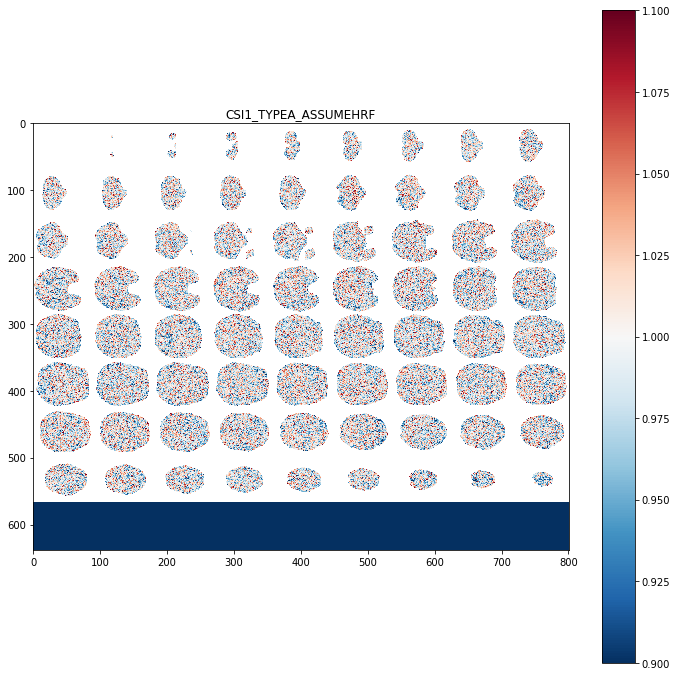

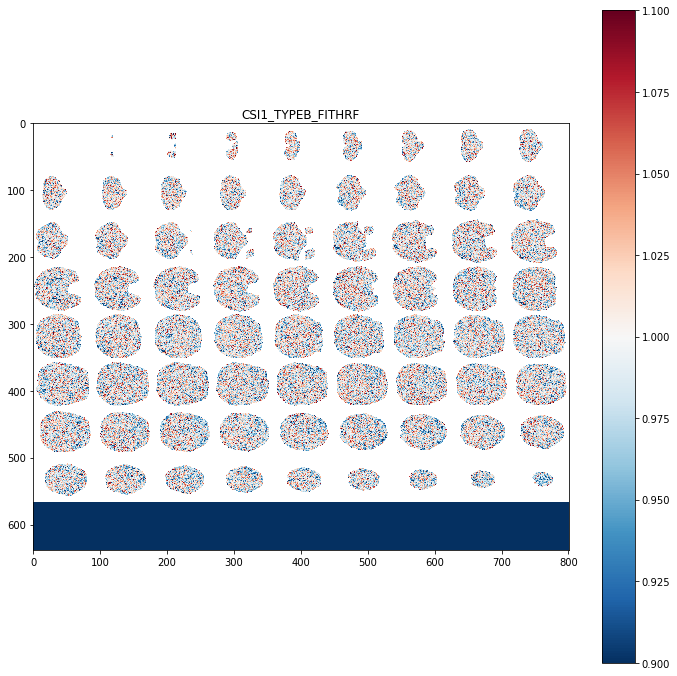

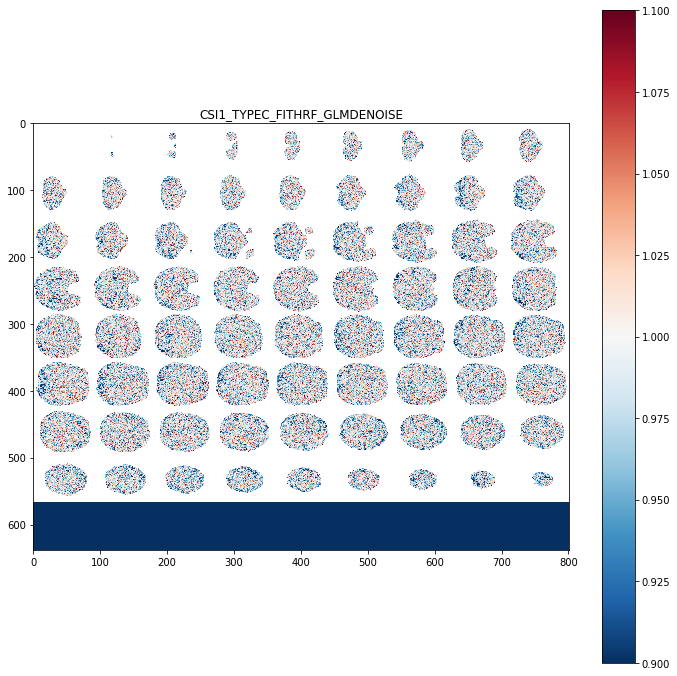

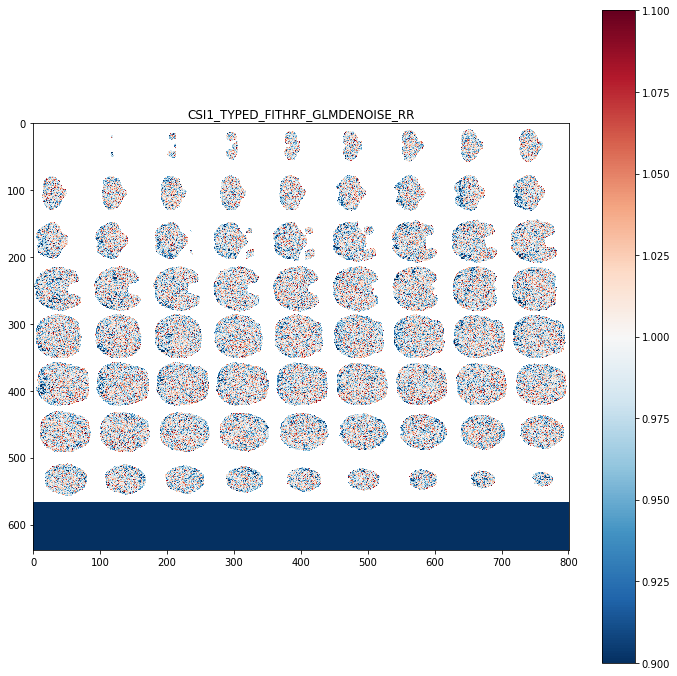

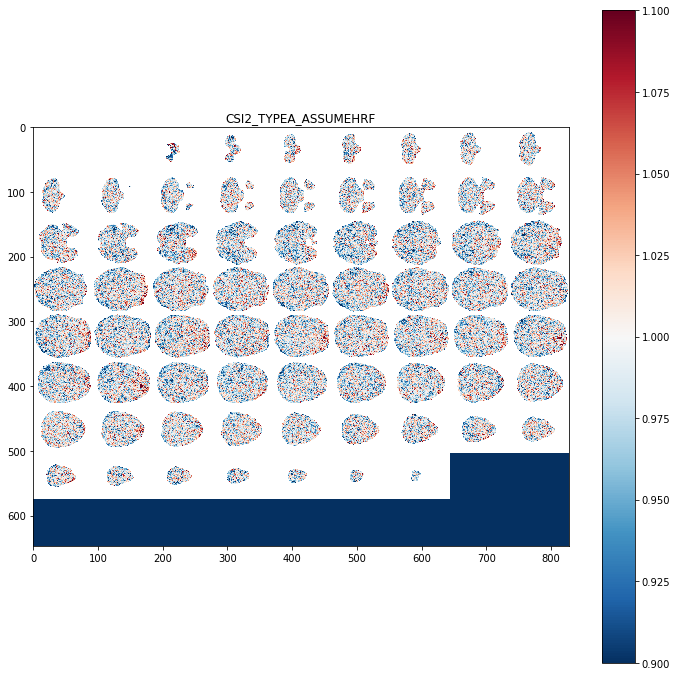

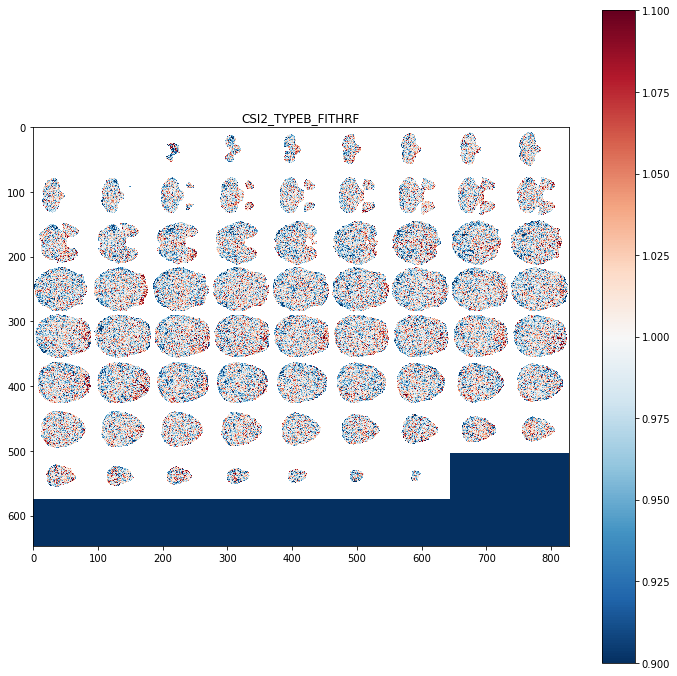

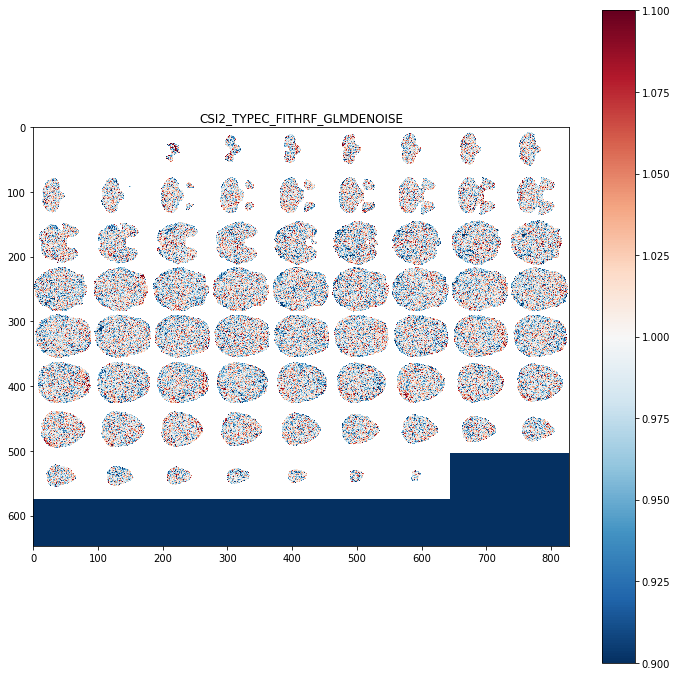

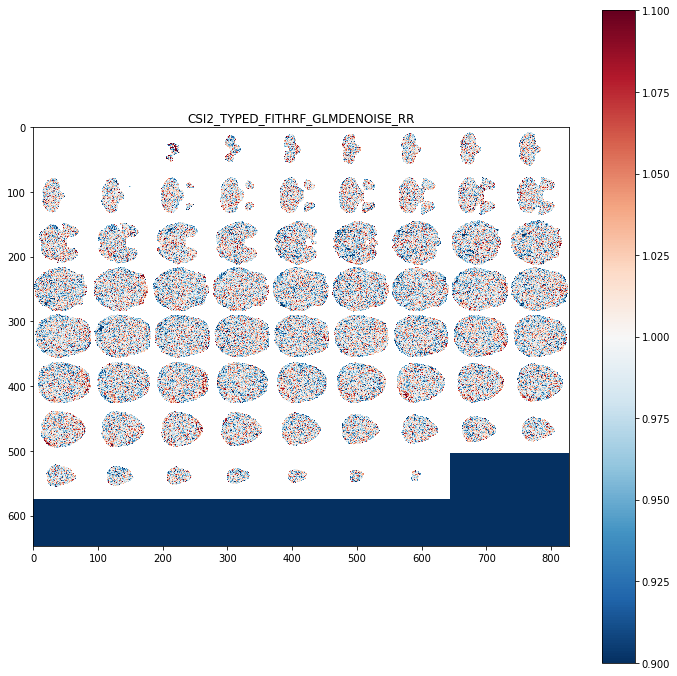

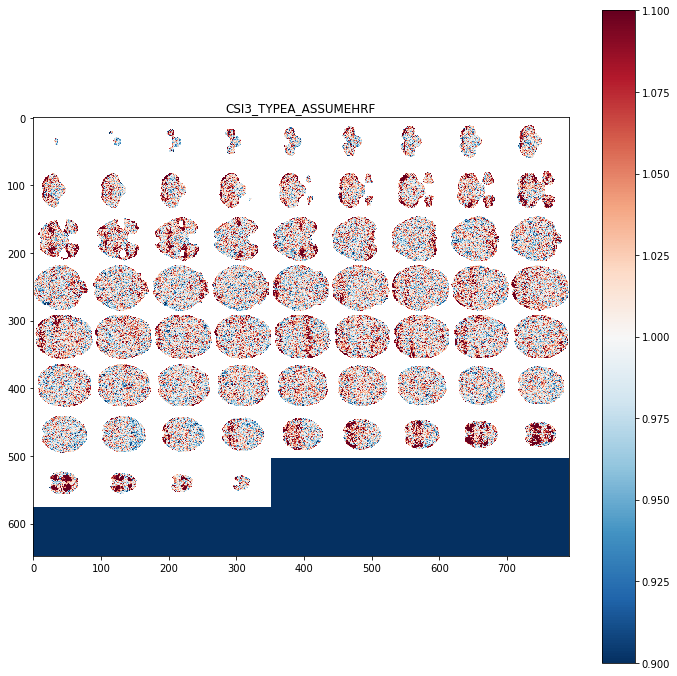

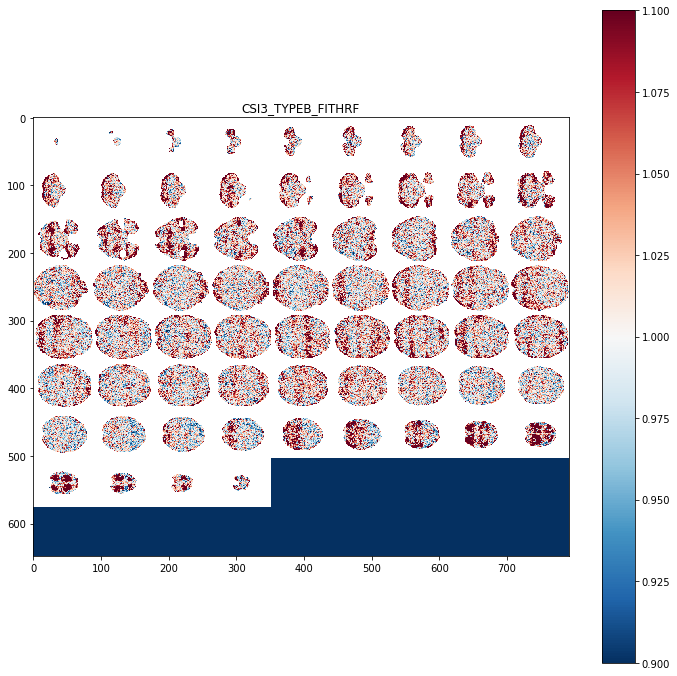

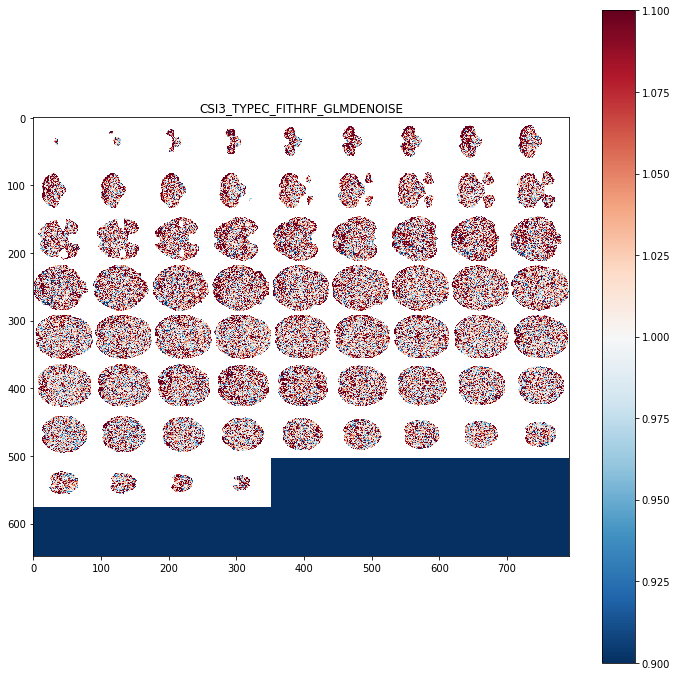

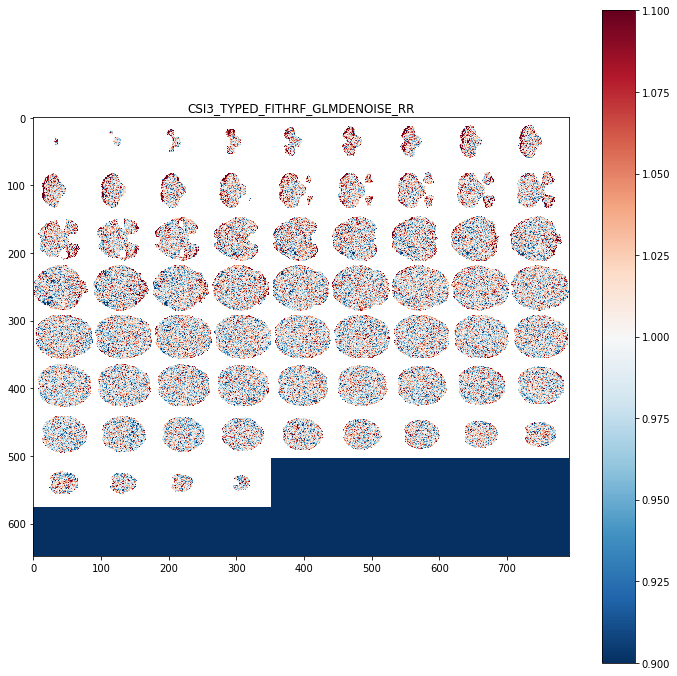

In [39]:
metric_sort = 'vmetric' #,'ncsnr','reliability']
metric = 'vmetric'
if 'v' in metric_sort:
    clims = (0.9,1.1)
    vals = np.round(np.arange(0,1.5,0.01),2)
elif 'snr' in metric_sort:
    clims = (0, 70)
    vals = np.round(np.arange(0,70,1),2)
elif 'rel' in metric_sort:
    clims = (-0.2,0.2)
    vals = np.round(np.arange(-0.1,0.6,0.025),3)

dates = ['08_24_20']#,'08_14_20']
subjs = ['CSI1','CSI2','CSI3']
groupings = ['one-sess']#,'three-sess','five-sess']
versions = ['TYPEA_ASSUMEHRF', 'TYPEB_FITHRF', 'TYPEC_FITHRF_GLMDENOISE', 'TYPED_FITHRF_GLMDENOISE_RR']
ft = 16
colors = ['blue','orange','green','red']

s = 1

for subj in subjs:
    #plt.figure(figsize=(36,8))

    for grouping in groupings:

        for date in dates:
            
            if '24' in date:
                linealpha = 1
            else:
                linealpha = 0.5
                
            metricdir = f'/home/jacobpri/git/BOLD5000-GLMs/betas/{date}_{grouping}/metrics_v2'
            assert(exists(metricdir))

            files = os.listdir(metricdir)
            subj_files = [file for file in files if subj in file and metric in file]

            all_metrics = []
            all_metrics_sort = []
            #c=1
            for version in versions:
                #plt.subplot(1,4,c)
                fn = join(metricdir, f'{subj}_{version}_{metric}')
                fn_sort = join(metricdir, f'{subj}_{version}_{metric_sort}')
                all_metrics.append(sio.loadmat(fn)[metric])
                all_metrics_sort.append(sio.loadmat(fn_sort)[metric_sort])
                #plt.scatter(all_metrics[-1],all_metrics_sort[-1],0.1)
                #plt.title(f'{subj}_{version}')
                #plt.xlabel(metric)
                #plt.ylabel(metric_sort)
    
                #c+=1
    
    v = 0
    for version in versions:
        plt.figure(figsize=(12,12))
        plt.imshow(make_img_stack(all_metrics[v]),cmap='RdBu_r',clim=clims)
        plt.colorbar()
        plt.title(f'{subj}_{version}')
        v+=1



/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less
/home/jacobpri/Gating/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater


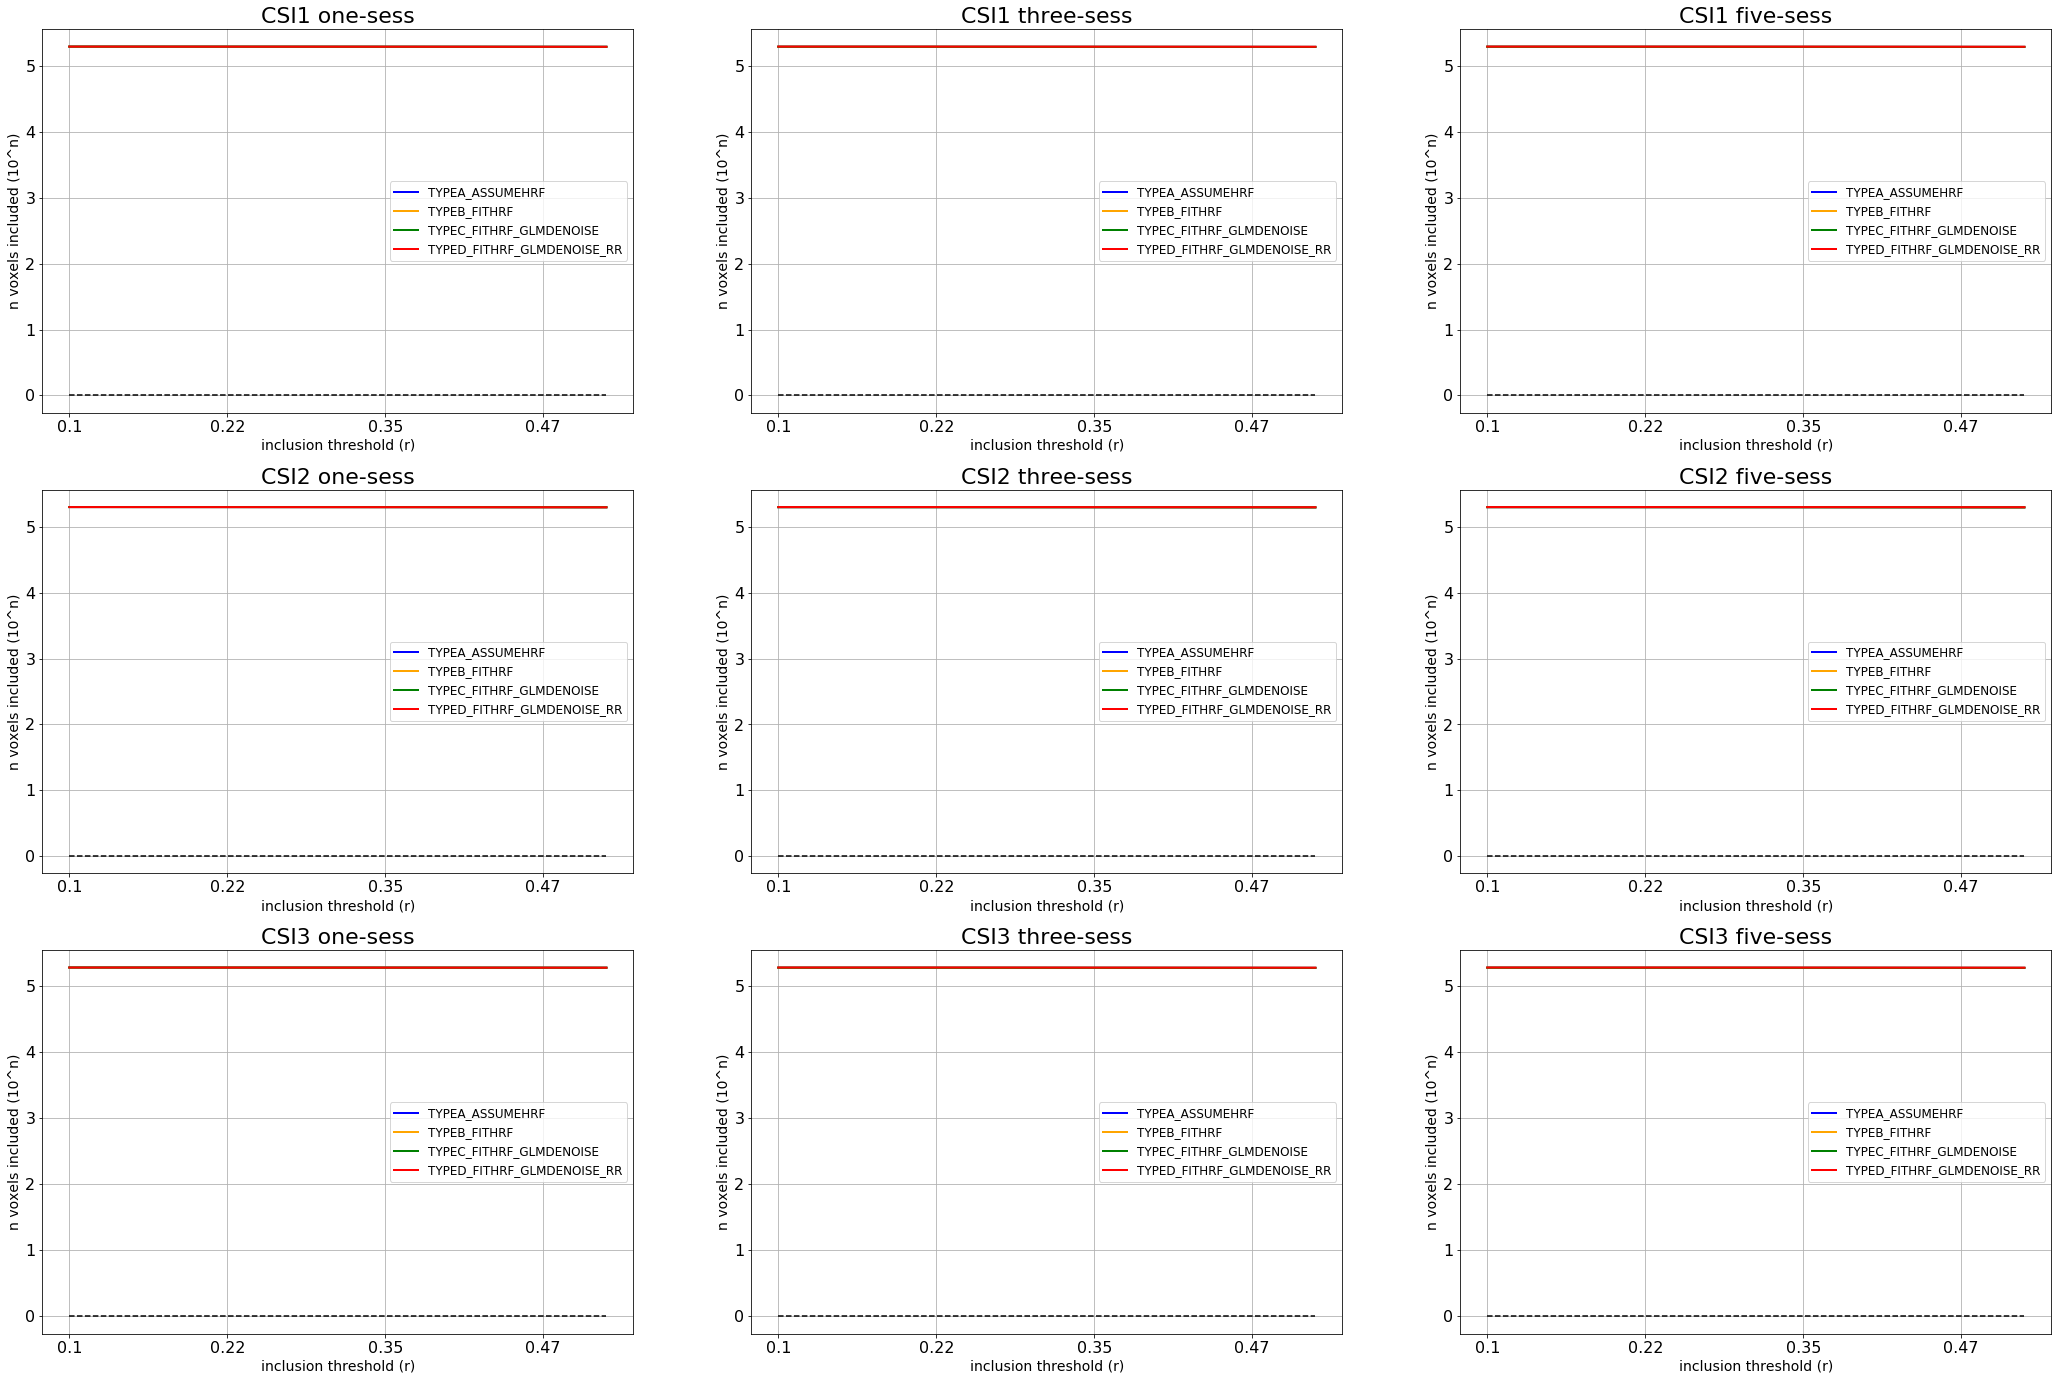

In [70]:
s = 1
vals = np.round(np.arange(0.1,0.55,0.025),2)
plt.figure(figsize=(36,24))

for subj in subjs:

    for grouping in groupings:

        for date in dates:
            
            if '24' in date:
                linealpha = 1
            else:
                linealpha = 0.5
                
            metricdir = f'/home/jacobpri/git/BOLD5000-GLMs/betas/{date}_{grouping}/metrics'
            assert(exists(metricdir))

            files = os.listdir(metricdir)
            subj_files = [file for file in files if subj in file and metric in file]

            all_metrics = []

            for version in versions:
                fn = join(metricdir, f'{subj}_{version}_{metric}')
                all_metrics.append(sio.loadmat(fn)[metric])

            subj_mean_metric = np.nanmean(np.stack(all_metrics,axis=3),axis=3)

            plt.subplot(3,3,s)
            c = 0
            for version in versions:
                proportions = []
                voxcounts = []
                for val in vals:
                    if 'v' in metric:
                        mask = subj_mean_metric < val
                    else:
                        mask = subj_mean_metric > val
                    X_this_version = all_metrics[c][mask]
                    voxcounts.append(np.log10(np.sum(all_metrics[c]>val)))

                plt.plot(voxcounts,linewidth=2,color = colors[c],alpha=linealpha)
                c+=1

        plt.plot(np.zeros((len(vals),)),'k--')
        plt.xticks(np.arange(len(vals))[::5],np.array(vals[::5]),fontsize=ft)
        plt.legend(versions,fontsize=ft-4)
        plt.yticks(fontsize=ft)
        plt.grid('on')
        plt.title(f'{subj} {grouping}',fontsize=ft+6)
        plt.xlabel('inclusion threshold (r)',fontsize=ft-2)
        plt.ylabel('n voxels included (10^n)',fontsize=ft-2)
        s+=1

In [292]:
for version in ['TYPEA_ASSUMEHRF','TYPEB_FITHRF']:

    for subj in subjs:

        for grouping in ['one-sess']:

            date_repbetas = []

            for date in dates:

                if '24' in date:
                    linealpha = 1
                else:
                    linealpha = 0.5

                metricdir = f'/home/jacobpri/git/BOLD5000-GLMs/betas/{date}_{grouping}/rep_betas'
                
                assert(exists(metricdir))

                files = os.listdir(metricdir)
                subj_files = [file for file in files if subj in file and metric in file]

                fn = join(metricdir, f'{subj}_{version}_rep_betas.mat')
                print(fn)
                date_repbetas.append(sio.loadmat(fn)['rep_betas'])
                print(date_repbetas[-1].shape)
                
            a = np.nanmean(date_repbetas[0])
            b = np.nanmean(date_repbetas[1])
            
            print(a,b)
            assert(np.isclose(a,b))
        

/home/jacobpri/git/BOLD5000-GLMs/betas/08_24_20_one-sess/rep_betas/CSI1_TYPEA_ASSUMEHRF_rep_betas.mat
(71, 89, 72, 4, 112)
/home/jacobpri/git/BOLD5000-GLMs/betas/08_14_20_one-sess/rep_betas/CSI1_TYPEA_ASSUMEHRF_rep_betas.mat
(71, 89, 72, 4, 112)
0.00036806424 0.00036806424
/home/jacobpri/git/BOLD5000-GLMs/betas/08_24_20_one-sess/rep_betas/CSI2_TYPEA_ASSUMEHRF_rep_betas.mat
(72, 92, 70, 4, 112)
/home/jacobpri/git/BOLD5000-GLMs/betas/08_14_20_one-sess/rep_betas/CSI2_TYPEA_ASSUMEHRF_rep_betas.mat
(72, 92, 70, 4, 112)
-0.009756329 -0.00975633
/home/jacobpri/git/BOLD5000-GLMs/betas/08_24_20_one-sess/rep_betas/CSI3_TYPEA_ASSUMEHRF_rep_betas.mat
(72, 88, 67, 4, 107)
/home/jacobpri/git/BOLD5000-GLMs/betas/08_14_20_one-sess/rep_betas/CSI3_TYPEA_ASSUMEHRF_rep_betas.mat
(72, 88, 67, 4, 107)
0.0027037829 0.0027037833
/home/jacobpri/git/BOLD5000-GLMs/betas/08_24_20_one-sess/rep_betas/CSI1_TYPEB_FITHRF_rep_betas.mat
(71, 89, 72, 4, 112)
/home/jacobpri/git/BOLD5000-GLMs/betas/08_14_20_one-sess/rep_be

In [287]:
a = date_repbetas[0].reshape(-1)


203825664

In [288]:
np.nanmean(a)

0.0003680724